In [1]:
%reset
%matplotlib inline

import netCDF4 as nc
import cmocean
import numpy as np
import xarray as xr
import xrft
from xgcm import Grid
import matplotlib.pyplot as plt
import scipy.interpolate
from dask.diagnostics import ProgressBar
from matplotlib import colors, ticker
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
forcing=xr.open_dataset('NW2_forcing.nc', decode_times=False) #This is for the 1/8 degree case


# #1/4 degree resolution, surface diagnostics are for uppermost 5 meters.
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.25deg_N15_baseline_hmix5/
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
av = xr.open_dataset('averages_00031502.nc', decode_times=False)  #100 5-day averages


# #1/32 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
#                         'sub05/ocean.stats.nc','sub06/ocean.stats.nc','sub07/ocean.stats.nc','sub08/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00002702.nc', decode_times=False)  #20 5-day averages
# #av = xr.open_mfdataset(['averages_00002302.nc','averages_00002402.nc','averages_00002502.nc','averages_00002602.nc','averages_00002702.nc'], decode_times=False)  #20 5-day averages

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis
/glade/campaign/univ/unyu0004/NeverWorld2/nw2_0.25deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
lat= (av.yh)     
lon= (av.xh)     

u= av.u[:,0,:,:]-(av.u[:,0,:,:].mean('time')) #We're removing the temporally-averaged mean flow.
v= av.v[:,0,:,:]-(av.v[:,0,:,:].mean('time'))
Ld = av.Rd1[:].mean('time')
grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
#Interpolating u,v to be on the same grid points:
dx= grid.interp(fs.dxCu,axis='X')
dy= grid.interp(fs.dyCv,axis='Y')
u = grid.interp(u,axis='X')
v = grid.interp(v,axis='Y')
print(u.shape,v.shape)
Ld = av.Rd1[:].mean('time')

(100, 560, 240) (100, 560, 240)


(560, 240)


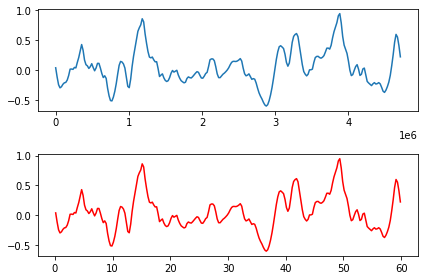

In [4]:
xi=dx.cumsum(axis=1)-dx[:,0] #subtract first dx so that we start at x=0m.


index=100
xline= xi[index,:]
uline= u[:,index,:]; uline=uline.assign_coords(xh=xline)
vline= v[:,index,:]; vline=uline.assign_coords(xh=xline)

print(xi.shape)

fig, ax = plt.subplots(2)
ax[0].plot(uline.xh,uline[0,:])
ax[1].plot(u[0,index,:].xh,u[0,index,:],'r')
plt.tight_layout()

### Computing the 1D spectrum at one latitude

In [5]:
time=np.arange(0,1,1)

boundary=50 #50
for i in range(75,76):#,len(lat)):

    
    xline= xi[i,boundary:-boundary]
    uline= u[time,i,boundary:-boundary].fillna(0.); uline=uline.assign_coords(xh=xline) 
    vline= v[time,i,boundary:-boundary].fillna(0.); vline=vline.assign_coords(xh=xline)
    Ldline= Ld[i,boundary:-boundary]; Ldline=Ldline.assign_coords(xh=xline)
    
    uiso2 = xrft.power_spectrum(uline,dim=['xh'], scaling="density",window='hann', detrend='linear').compute() #, window='hann/hamming', detrend='linear'
    viso2 = xrft.power_spectrum(vline,dim=['xh'], scaling="density",window='hann', detrend='linear').compute()
    ekeiso = .5*(uiso2 + viso2).mean('time') #Computing the mean spectrum first, then finding max wavenumber later.
    #ekeiso = .5*(viso2).mean('time') #Computing the mean spectrum first, then finding max wavenumber later.

    nk = int(len(ekeiso)/2.)

    ekeiso=ekeiso[nk+1:]    # half of the latitude array size
    wavenumber= (ekeiso.freq_xh*1e3*2*np.pi)
    LD_wavenumber=(1/(Ldline/1000)).mean('xh')
    ES_wavenumber=ekeiso[3:].idxmax(dim='freq_xh')*1000*2*np.pi #don't count first 3 wavenumbers
  
    alt_PS=0.5*(np.abs(np.fft.rfft(vline))**2) #units m2/s2
    #alt_PS=0.5*(np.abs(np.fft.rfft(uline))**2)+0.5*(np.abs(np.fft.rfft(vline))**2) #units m2/s2
    #alt_PS=alt_PS/(int(len(xline))**2)       #if using scaling spectrum, preserves units m2/s2 (my interpretation)
    alt_PS=alt_PS*np.array(dx[i,100]/len(xline)) #if using scaling density, units m3/s2
    alt_freq= np.fft.rfftfreq(uline.size,np.array(dx[i,100])/(1000*2*np.pi))
    
    centroid = np.nansum(ekeiso*wavenumber)/np.nansum(ekeiso)
    

### Computing the 1D spectrum at each latitude for all times:

In [1]:
time=np.arange(0,20,1)

lim = 20 #40 for HR
LD_wavenumber=Ld[lim:-lim,0]*0.0
ES_wavenumber=Ld[lim:-lim,0]*0.0
ES_stdev     =Ld[lim:-lim,0]*0.0

centroid      =Ld[lim:-lim,0]*0.0
centroid_stdev=Ld[lim:-lim,0]*0.0

boundary=lim
for i in range(lim,len(lat)-lim):#,len(lat)):

    
    xline= xi[i,boundary:-boundary]
    uline= u[time,i,boundary:-boundary]; uline=uline.assign_coords(xh=xline) 
    vline= v[time,i,boundary:-boundary]; vline=vline.assign_coords(xh=xline)
    Ldline= Ld[i,boundary:-boundary]; Ldline=Ldline.assign_coords(xh=xline)
    
    uiso2 = xrft.power_spectrum(uline,dim=['xh'],scaling="density").compute() #generally don't want window and detrending when using the centroid, they change shape.
    viso2 = xrft.power_spectrum(vline,dim=['xh'],scaling="density").compute()
    #ekeiso = .5*(uiso2 + viso2)
    ekeiso = .5*(viso2)

    nk = int(len(ekeiso[1])/2.)
    ekeiso=ekeiso[:,nk+1:]    #460 in length, half of the used longitude array (20-940)
    
    ES_stdev[i-lim]     =(1./(ekeiso[:,3:].idxmax(dim='freq_xh')*1000*2*np.pi)).std('time').values
    ES_wavenumber[i-lim]=(ekeiso[:,3:].idxmax(dim='freq_xh')*1000*2*np.pi).mean('time').values #don't count first 3 wavenumbers, compute most energetic wavenumber then average over time
    LD_wavenumber[i-lim]=(1/(Ldline/1000)).mean('xh').values
    wavenumber= (ekeiso.freq_xh*1e3*2*np.pi)
    
    centroid[i-lim] = ((ekeiso*wavenumber).sum('freq_xh')/ekeiso.sum('freq_xh')).mean('time')
    centroid_stdev[i-lim]=(1/((ekeiso*wavenumber).sum('freq_xh')/ekeiso.sum('freq_xh'))).std('time')
    ekeiso=ekeiso.mean('time')
    print(i)
    
    


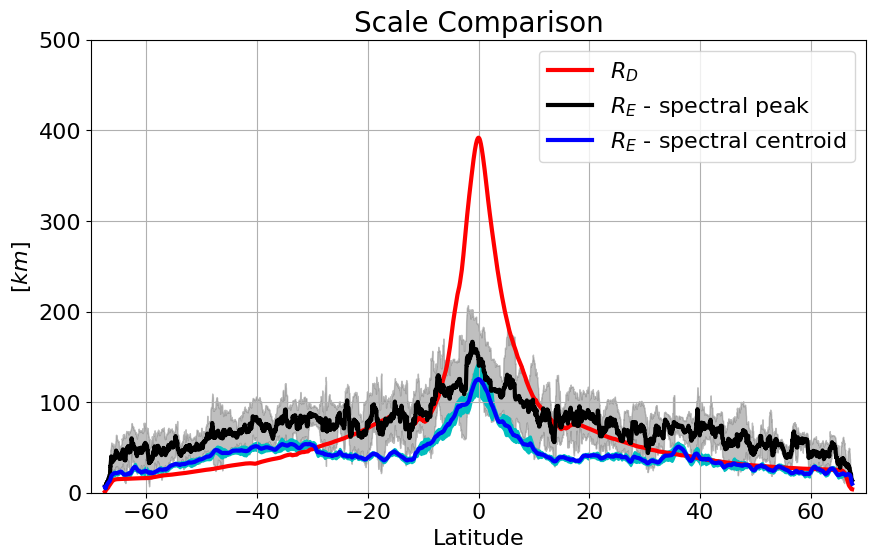

In [14]:

fig, ax = plt.subplots(figsize=(10,6),dpi=100)


plt.plot(LD_wavenumber.yh,1./LD_wavenumber,'-',c='r',linewidth=3,label='$R_D$')
plt.plot(ES_wavenumber.yh,1./ES_wavenumber,'-',c='k',linewidth=3,label='$R_E$ - spectral peak')
plt.fill_between(ES_wavenumber.yh, 1./(ES_wavenumber)+ES_stdev, 1./(ES_wavenumber)-ES_stdev,color=(0.5,0.5,0.5,0.5))

plt.plot(centroid.yh,1./centroid,'-',c='b',linewidth=3,label='$R_E$ - spectral centroid')
plt.fill_between(centroid.yh, 1./(centroid)+centroid_stdev, 1./(centroid)-centroid_stdev,color='c')

plt.title('Scale Comparison',fontsize=20)
plt.ylim([0, 500]); plt.xticks(fontsize=16);
plt.xlim([-70, 70]); plt.yticks(fontsize=16);
plt.grid()
plt.xlabel('Latitude',fontsize=16); plt.ylabel('$[km]$',fontsize=16);
plt.legend(fontsize=16)

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

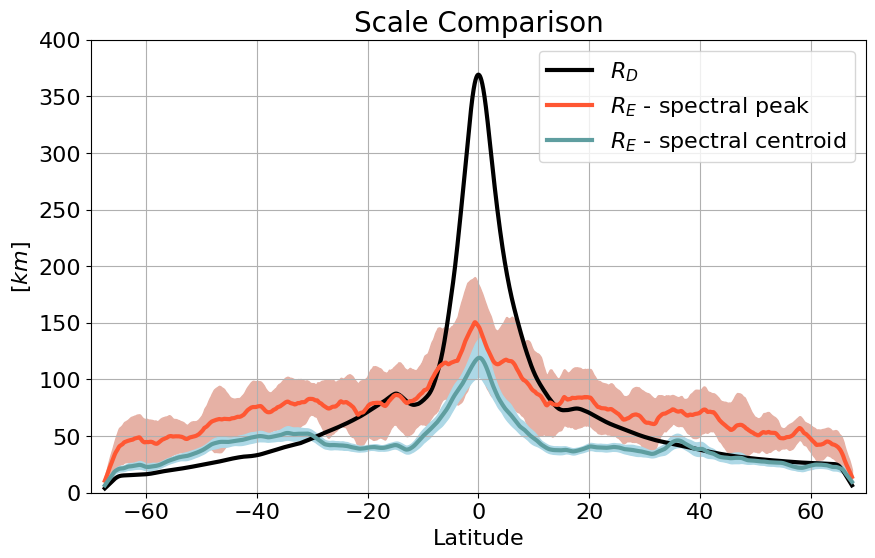

In [15]:

fig, ax = plt.subplots(figsize=(10,6),dpi=100)

window=100
smooth_ES=np.convolve(1./ES_wavenumber, np.ones((window,))/window, mode='same')
smooth_LD=np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same')
smooth_ES_stdev     =np.convolve(ES_stdev, np.ones((window,))/window, mode='same')

smooth_centroid=np.convolve(1./centroid, np.ones((window,))/window, mode='same')
smooth_centroid_stdev=np.convolve(centroid_stdev, np.ones((window,))/window, mode='same')



plt.plot(LD_wavenumber.yh,smooth_LD,'-',c='k',linewidth=3,label='$R_D$')
plt.plot(ES_wavenumber.yh,smooth_ES,'-',c='#FF5733',linewidth=3,label='$R_E$ - spectral peak')
plt.fill_between(ES_wavenumber.yh, smooth_ES+smooth_ES_stdev, smooth_ES-smooth_ES_stdev,color='#e6b1a5')

plt.plot(centroid.yh,smooth_centroid,'-',c='#5F9EA0',linewidth=3,label='$R_E$ - spectral centroid')
plt.fill_between(centroid.yh, smooth_centroid+smooth_centroid_stdev, smooth_centroid-smooth_centroid_stdev,color='#ADD8E6')

plt.title('Scale Comparison',fontsize=20)
plt.ylim([0, 400]); plt.xticks(fontsize=16);
plt.xlim([-70, 70]); plt.yticks(fontsize=16);
plt.grid()
plt.xlabel('Latitude',fontsize=16); plt.ylabel('$[km]$',fontsize=16);
plt.legend(fontsize=16)

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

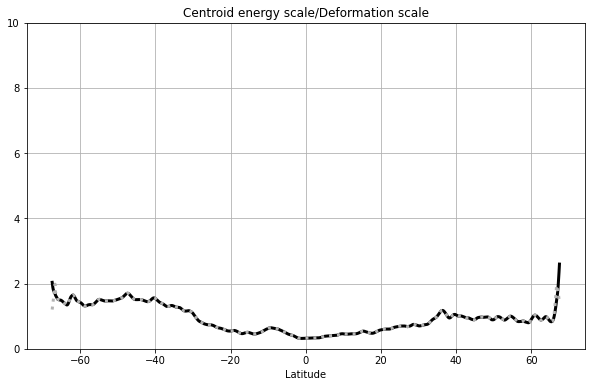

In [16]:
fig, ax = plt.subplots(figsize=(10,6))


 
window=50
smooth_centroid=np.convolve(1./centroid, np.ones((window,))/window, mode='same')
smooth_LD=np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same')
smooth_centroid_LD=np.convolve(LD_wavenumber/centroid, np.ones((window,))/window, mode='same')

#plt.plot(ES_wavenumber.yh,c,'-',c=[.7,.7,.7],linewidth=3,label='Energy containing scale')
plt.plot(centroid.yh,(smooth_centroid/smooth_LD),'-',c='k',linewidth=3,label='Energy containing scale')
plt.plot(centroid.yh,smooth_centroid_LD,':',c=[.7,.7,.7],linewidth=3,label='Energy containing scale')


plt.title('Centroid energy scale/Deformation scale')
plt.ylim([0, 10])
#plt.xlim([-6500, 6500])
plt.grid()
plt.xlabel('Latitude'); 
#plt.ylabel('$[km]$');

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

In [17]:
#COMPUTE velocity components for decomposing KE:
Nlayers=15

h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(20, 15, 4480, 1920)


In [19]:
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x
print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')

print('done 2')
# #Total kinetic energy:
KE_BT_tot=KE_eddy_BT+KE_mean_BT
KE_BC_tot=KE_eddy_BC+KE_mean_BC
KE_tot=KE_BT_tot+KE_BC_tot


fraction_BT=KE_BT_tot/KE_tot
fraction_BT_mean=KE_mean_BT/KE_tot
fraction_BT_eddy=KE_eddy_BT/KE_tot

fraction_BC=KE_BC_tot/KE_tot#when you divide zero/zero it's a nan
fraction_BC_mean=KE_mean_BC/KE_tot
fraction_BC_eddy=KE_eddy_BC/KE_tot

KE_eddy = KE_eddy_BT+ KE_eddy_BC
KE_mean = KE_mean_BT+ KE_mean_BC

done 1
done 2


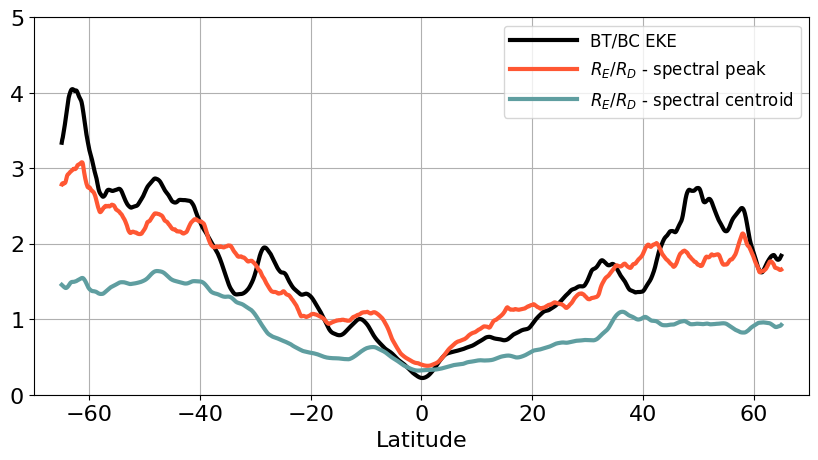

In [21]:
window=100

plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
yh_center=av.yh[lim:-lim]
Eddy_BC=(KE_eddy_BC.mean('xh'))[lim:-lim];
Eddy_BT=(KE_eddy_BT.mean('xh'))[lim:-lim];

BT_BC=np.convolve((Eddy_BT/Eddy_BC), np.ones((window,))/window, mode='same')
LES_LD=np.convolve((LD_wavenumber/ES_wavenumber), np.ones((window,))/window, mode='same')
LEC_LD=np.convolve((LD_wavenumber/centroid), np.ones((window,))/window, mode='same')

bound1=80; bound2=-80
plt.plot(yh_center[bound1:bound2],BT_BC[bound1:bound2],'-',c='k',linewidth=3)

plt.plot(yh_center[bound1:bound2],LES_LD[bound1:bound2],'-',c='#FF5733',linewidth=3)
plt.plot(yh_center[bound1:bound2],LEC_LD[bound1:bound2],'-',c='#5F9EA0',linewidth=3)


plt.legend(['BT/BC EKE','$R_E/R_D$ - spectral peak','$R_E/R_D$ - spectral centroid'],loc='upper right',fontsize=12,handlelength=4)
#plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.ylim([0, 5]); plt.xticks(fontsize=16);
plt.xlim([-70, 70]); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
#plt.ylabel('Fraction')
#plt.title('1/32$^\circ$')
plt.grid()